# Machine learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
train = pd.read_csv("/data/train.csv")
test = pd.read_csv("/data/test.csv")

## Part 1: Classification tree on economy advantage with no modifications

For the first model we implement directly a classification tree based on numerical economic Advantage and categorical Result. We will use economic Advantage as the predictor and Result is our response (1.0 for team 1 winning, 2.0 for team 2 winning). 

### Preparation

In [ ]:
trainCopy = train

In [ ]:
classEconomy = pd.DataFrame(columns=['Advantage', 'Result'])

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([trainCopy[advantageString], trainCopy[winnerString]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Advantage', 1: 'Result'}, inplace = True)

  classEconomy = pd.concat([classEconomy, tempFrame], axis = 0, ignore_index = True)

classEconomy = classEconomy[classEconomy["Result"] != 0.0]
classEconomy = classEconomy[classEconomy["Advantage"] != -5]
advClassTrain = pd.DataFrame(classEconomy['Advantage'])
resClassTrain = pd.DataFrame(classEconomy['Result'])

In [ ]:
testCopy = test
testCopy.shape

(8232, 129)

In [ ]:
testEconomy = pd.DataFrame(columns=['Advantage', 'Result'])

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([testCopy[advantageString], testCopy[winnerString]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Advantage', 1: 'Result'}, inplace = True)

  testEconomy = pd.concat([testEconomy, tempFrame], axis = 0, ignore_index = True)


testEconomy = testEconomy[testEconomy["Result"] != 0]
testEconomy = testEconomy[testEconomy["Advantage"] != -5]
testFrame = pd.DataFrame(testEconomy["Advantage"])
actualFrame = pd.DataFrame(testEconomy["Result"])


### Training

In [ ]:
clftree = DecisionTreeClassifier(max_depth = 10)

In [ ]:
resClassTrain.value_counts()

Result
1.0       429685
2.0       403643
dtype: int64

In [ ]:
clftree.fit(advClassTrain, resClassTrain)

DecisionTreeClassifier(max_depth=10)


note: positive advantage means t1 spends more, vice versa

### Testing

In [ ]:
test_pred_tree = clftree.predict(testFrame)
predtree = clftree.score(testFrame, actualFrame)

In [ ]:
confusion_matrix = metrics.confusion_matrix(actualFrame, test_pred_tree)
confusion_matrix = pd.DataFrame(confusion_matrix)
labels = ["1_win", "2_win"]

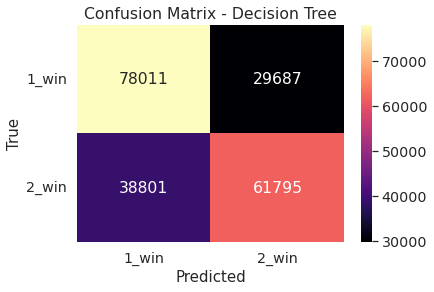

<Figure size 720x504 with 0 Axes>

In [ ]:
ax = plt.axes()
sb.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sb.heatmap(confusion_matrix, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

### Evaluation

In [ ]:
print(metrics.classification_report(actualFrame, test_pred_tree))

              precision    recall  f1-score   support

         1.0       0.67      0.72      0.69    107698
         2.0       0.68      0.61      0.64    100596

    accuracy                           0.67    208294
   macro avg       0.67      0.67      0.67    208294
weighted avg       0.67      0.67      0.67    208294



We see that the model accuracy is 0.67. Hence, our model can on average predict correctly for 2 out of 3 matches. However, we also observe there is a high number of predicted wins (about 18.6%) for team 1 that are actually won by team 2. This can be due to pistol rounds where there is no difference in economy and eco rounds where a team strategically chooses to spend less. 

We also noticed that increasing the tree's depth further than 10 does not meaningfully increase the model's prediction accuracy. Improving our model will require modifications to our classification method.

## Part 2: Attempt at improving the model

The base model offers a good starting point to fine tune our model. Next we try using an ensemble tree to see if it can lead us to a higher prediction accuracy. 

We have discovered that some maps have a bias towards Terrorist or Counter-Terrorist. We will try to incorporate this as a predictor.

## Histogram-based Gradient Boosting Classifier

### Preparation

In [ ]:
trainCopy2 = train
classv2 = pd.DataFrame(columns=['Advantage', 'Result', 'map'])

In [ ]:
mapdict = { 'Cache' : '1'  , 'Vertigo' : '2' , 'Mirage' : '3' , 'Dust2' : '4', 'Cobblestone' : '5', 'Inferno' : '6', 'Overpass' : '7', 'Nuke' : '8', 'Train' : '9'}

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([trainCopy2[advantageString], trainCopy2[winnerString], trainCopy2["_map"]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Advantage', 1: 'Result', 2: 'map'}, inplace = True)

  classv2 = pd.concat([classv2, tempFrame], axis = 0, ignore_index = True)

classv2['map'] = classv2['map'].map(mapdict)
classv2 = classv2[classv2["Result"] != 0]
classv2 = classv2[classv2["Advantage"] != -5]

In [ ]:
gbc = GradientBoostingClassifier()

x_train = pd.DataFrame(classv2[["Advantage", "map"]])
y_train = pd.DataFrame(classv2["Result"])

In [ ]:
testCopy2 = test

In [ ]:
testv2 = pd.DataFrame(columns=['Advantage', 'Result', 'map'])

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([testCopy2[advantageString], testCopy2[winnerString], testCopy2["_map"]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Advantage', 1: 'Result', 2: 'map'}, inplace = True)

  testv2 = pd.concat([testv2, tempFrame], axis = 0, ignore_index = True)

In [ ]:
testv2 = testv2[testv2["Result"] != 0]
testv2 = testv2[testv2["Advantage"] != -5]

In [ ]:
testv2['map'] = testv2['map'].map(mapdict)

### Training

In [ ]:
clfboost = HistGradientBoostingClassifier(categorical_features=[1], loss = 'binary_crossentropy').fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Testing & Evaluation

In [ ]:
x_test = pd.DataFrame(testv2[["Advantage", "map"]])
y_test = pd.DataFrame(testv2["Result"])

boostTreePred = clfboost.score(x_test, y_test)

In [ ]:
print(boostTreePred)

0.6721605039031369


We see that the accuracy score is 0.67 which is the same as the previous model. This means that map bias does not significantly affect the outcome of a round as compared to economic advantage.

This is to be expected as when the advantage is within +-3000 gold, the firepower differences between the two teams are not significant as the economy advantage can be attributed to the difference in the economic investments for CTs and T side respectively (CTs generally have more expensive guns than Ts and need to buy defuse kits). Hence, the weak learners (with low depths) will have inaccurate predictions for rounds within this range (rounds are closer to 50-50 in this range). Since majority of rounds are within this range, the final classification accuracy may not change as well.


## Random Forest Classifier

For Random forest, we decide to incorporate more predictors such as team matchup to try and increase our prediction accuracy.

### Preparation

In [ ]:
trainCopy3 = train

In [ ]:
classNN = pd.DataFrame(columns = ['Team 1', 'Team 2', 'Map', 'Advantage', 'Result'])

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([trainCopy3["team_1"], trainCopy3["team_2"], trainCopy3["_map"], trainCopy3[advantageString], trainCopy3[winnerString]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Team 1', 1: 'Team 2', 2: 'Map', 3: 'Advantage', 4: 'Result'}, inplace = True)

  classNN = pd.concat([classNN, tempFrame], axis = 0, ignore_index = True)

In [ ]:
teamscolumns = cleancopy["team_1"].append(cleancopy["team_2"])
teamsList = teamscolumns.tolist()
teamsList = dict.fromkeys(teamsList)
sortTeams = {key: val for key, val in sorted(teamsList.items(), key = lambda ele: ele[0], reverse = False)}
keys = list(sortTeams.keys())

In [ ]:
i=0
for item in keys:
  sortTeams.update({item : i})
  i+=1 

In [ ]:
classNN = classNN[classNN["Result"] != 0] 
classNN = classNN[classNN["Advantage"] != -5] 

In [ ]:
testCopy3 = testCopy

In [ ]:
testNN = pd.DataFrame(columns = ['Team 1', 'Team 2', 'Map', 'Advantage', 'Result'])

In [ ]:
for i in range(1,31):
  advantageString  = str(i) + "_advantage"
  winnerString = str(i) + "_winner"

  
  tempFrame = pd.concat([testCopy3["team_1"], testCopy3["team_2"], testCopy3["_map"], testCopy3[advantageString], testCopy3[winnerString]], ignore_index = True, axis = 1)
  tempFrame.rename(columns = {0: 'Team 1', 1: 'Team 2', 2: 'Map', 3: 'Advantage', 4: 'Result'}, inplace = True)

  testNN = pd.concat([testNN, tempFrame], axis = 0, ignore_index = True)

In [ ]:
testNN = testNN[testNN["Result"] != 0] 
testNN = testNN[testNN["Advantage"] != -5] 

In [ ]:
classNN2 = classNN
testNN2 = testNN

In [ ]:
numeric_features = ["Advantage"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

categorical_features = ["Team 1", "Team 2", "Map"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)])

### Training & testing

In [ ]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(max_depth = 50))])

clf.fit(classNN2[["Team 1", "Team 2", "Map", "Advantage"]], classNN2["Result"])

forestpred = clf.score(testNN2[["Team 1", "Team 2", "Map", "Advantage"]], testNN2["Result"])


### Evaluation

Our prediction accuracy has not increased with even more predictors. Hence, round outcome is mostly affected by economic advantage instead of team matchups and map bias.

In [ ]:
print(forestpred)

0.66074874936388


## Part 3: Comparison of models


In [ ]:
comparisonFrame = pd.DataFrame({'Model' : ['Decision Tree Classifier', "Gradient Boosting Classifier", "Random Forest Classifier"], 'Accuracy' : [predtree, boostTreePred, forestpred]})

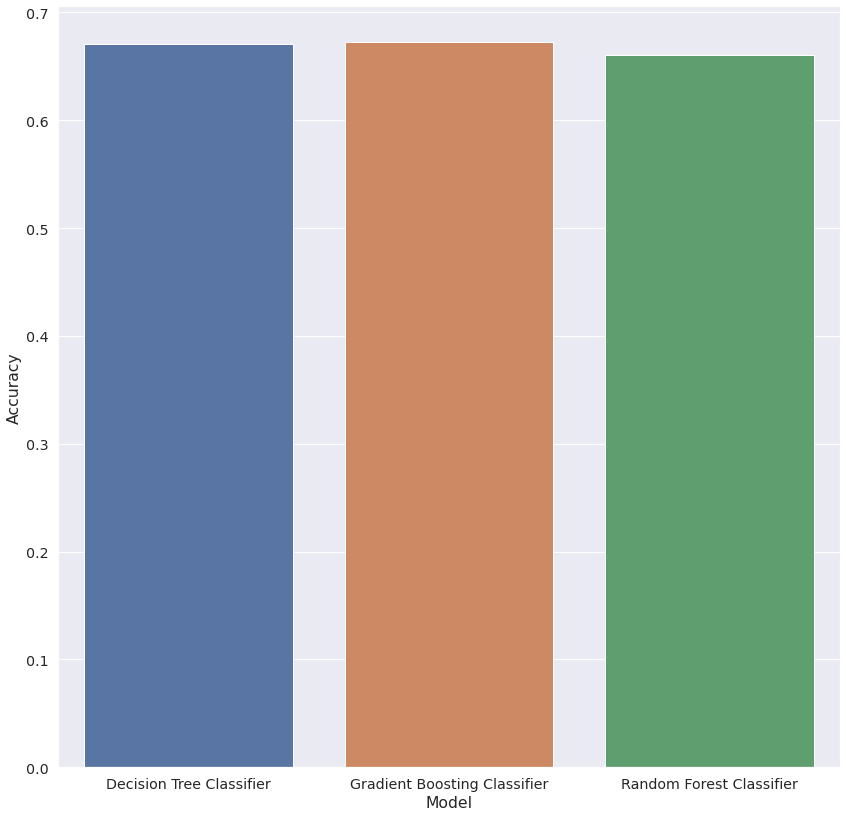

In [ ]:
sb.set(font_scale=1.3)
plt.figure(figsize=(14,14))
sb.barplot(x = comparisonFrame["Model"], y= comparisonFrame["Accuracy"], )

In [ ]:
print("Decision Tree Classifier Accuracy: " , predtree)
print("Gradient Boosting Classifier Accuracy: ", boostTreePred)
print("Random Forest Classifier Accuracy: ", forestpred)

Decision Tree Classifier Accuracy:  0.6711955217144997
Gradient Boosting Classifier Accuracy:  0.6721605039031369
Random Forest Classifier Accuracy:  0.66074874936388


Based on accuracy, we can choose between Decision Tree and Gradient Boosting Classifier. Gradient Boosting Classifier offers a very slightly higher accuracy, however, considering that Decision Tree Classifiers are faster and utilise less resources, our team still considers it the most optimal algorithm to use for predictions.